# Import Libraries and Clean Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, balanced_accuracy_score, f1_score, recall_score, precision_score

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize

In [2]:
subreddits = pd.read_csv('./data/posts_combined_clean.csv')

In [3]:
subreddits.head(3)

,subreddit,title,author,created_utc,upvote_ratio,full_link,num_comments,num_crossposts,total_awards_received,score
0,science,A Climate in Crisis Calls for Investment in Di...,Wagamaga,1610798299,1.0,https://www.reddit.com/r/science/comments/kyhp...,6,0,0,1
1,science,Cureus | Telemedicine: Current Impact on the F...,CureusJournal,1610798085,1.0,https://www.reddit.com/r/science/comments/kyho...,0,0,0,1
2,science,Magnetic reconnection as a mechanism for energ...,m3prx,1610792298,1.0,https://www.reddit.com/r/science/comments/kygi...,2,0,0,1


# Logistic Model

### X, y, train test split

In [4]:
X = subreddits['title']
y = subreddits['subreddit']

In [5]:
lgr = LogisticRegression()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)

### Baseline Model

In [7]:
y.value_counts(normalize=True)

science       0.572091
technology    0.427909
Name: subreddit, dtype: float64

In [8]:
# the target in the dataset for posts was split approximately 57% for r/science.
# This will be the baseline model - if we guessed r/science each time we would 
# be correct 57% of the time

### Logistic Regression

In [9]:
#pipeline with Countvectorizer ('english' stop words), Standard Scaler, Logistic Regression
logreg_pipe = make_pipeline(CountVectorizer(stop_words='english', max_features=500),
                    StandardScaler(with_mean=False),
                    LogisticRegression(max_iter=1000))

In [10]:
logreg_pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=500, stop_words='english')),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression', LogisticRegression(max_iter=1000))])>

In [11]:
params = {
    'countvectorizer__max_features': [100, 200, 500, 800, 1000],
    'countvectorizer__binary': ['True', 'False'],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid = GridSearchCV(logreg_pipe, params)

In [12]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=500,
                                                        stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'countvectorizer__binary': ['True', 'False'],
                         'countvectorizer__max_features': [100, 200, 500, 800,
                                                           1000],
                         'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100]})

In [13]:
pd.DataFrame(grid.cv_results_).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__binary,param_countvectorizer__max_features,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.138636,0.032395,0.020746,0.001325,True,100,0.001,"{'countvectorizer__binary': 'True', 'countvect...",0.761069,0.750209,0.739967,0.771739,0.774247,0.759446,0.012943,59
1,0.116279,0.004205,0.020155,0.000756,True,100,0.01,"{'countvectorizer__binary': 'True', 'countvect...",0.787803,0.787803,0.766722,0.768395,0.771739,0.776492,0.009375,49
2,0.149195,0.017225,0.027119,0.002994,True,100,0.1,"{'countvectorizer__binary': 'True', 'countvect...",0.788638,0.787803,0.765050,0.768395,0.768395,0.775656,0.010335,51
3,0.151802,0.027596,0.020948,0.001413,True,100,1,"{'countvectorizer__binary': 'True', 'countvect...",0.788638,0.787803,0.765050,0.767559,0.767559,0.775322,0.010575,53
4,0.139026,0.009152,0.019940,0.000632,True,100,10,"{'countvectorizer__binary': 'True', 'countvect...",0.788638,0.787803,0.765050,0.767559,0.767559,0.775322,0.010575,53


In [14]:
grid.best_params_

{'countvectorizer__binary': 'True',
 'countvectorizer__max_features': 1000,
 'logisticregression__C': 0.001}

### Model scores

In [15]:
preds = grid.best_estimator_.predict(X_test)

In [16]:
precision = precision_score(y_test, preds, pos_label='science')
recall = recall_score(y_test, preds, pos_label='science')
f1 = 2 * (precision * recall) / (precision + recall)

In [17]:
print(f'The accuracy training score is    {grid.score(X_train, y_train)}')
print(f'The accuracy testing score is     {grid.score(X_test, y_test)}')
print(f'The bac score is                  {balanced_accuracy_score(y_test, grid.predict(X_test))}')
print(f'The f1_score score is             {f1}')
print(f'The precision is                  {precision}')
print(f'The recall is                     {recall}')

The accuracy training score is    0.8956870611835507
The accuracy testing score is     0.8716148445336008
The bac score is                  0.8696193154438683
The f1_score score is             0.8873239436619719
The precision is                  0.8912466843501327
The recall is                     0.8834355828220859


- Slightly overfit - training score is higher than testing score.
- Balanced accuracy score of 0.82 - This is a fairly accurate classification model

### Confusion Matrix

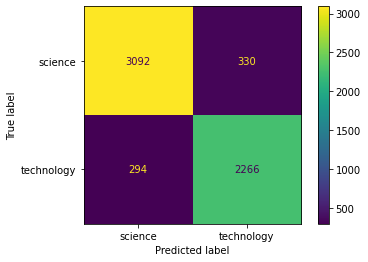

In [18]:
plot_confusion_matrix(grid, X_train, y_train);

- False positives: 472 were science, labeled as technology
- False negatives: 294 technology, labled as science

### Feature Importance

In [19]:
grid.get_params

<bound method BaseEstimator.get_params of GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=500,
                                                        stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'countvectorizer__binary': ['True', 'False'],
                         'countvectorizer__max_features': [100, 200, 500, 800,
                                                           1000],
                         'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100]})>

In [20]:
df_index = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names()

In [21]:
coefs = grid.best_estimator_.named_steps['logisticregression'].coef_
df_index = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names()
coef_df = pd.DataFrame({'coefs': coefs[0]}, index = df_index)
coef_df.nlargest(10, 'coefs')

,coefs
apple,0.121731
tech,0.117515
amazon,0.094915
2021,0.091522
google,0.089648
whatsapp,0.088452
app,0.087440
iphone,0.083929
internet,0.083200
twitter,0.081603


In [22]:
coef_df.nsmallest(10, 'coefs')

,coefs
study,-0.138342
science,-0.131191
scientists,-0.127439
covid,-0.095072
19,-0.091820
brain,-0.085276
researchers,-0.078939
research,-0.078366
cancer,-0.075582
health,-0.073238


### Predict proba

In [23]:
grid.predict_log_proba(X_test)

array([[-0.02606772, -3.66006319],
       [-0.01761103, -4.04802227],
       [-0.96624075, -0.47885999],
       ...,
       [-5.1370784 , -0.00589215],
       [-0.62837138, -0.7624113 ],
       [-0.56280883, -0.84305627]])

In [24]:
grid.predict_proba(X_test)

array([[0.97426911, 0.02573089],
       [0.98254313, 0.01745687],
       [0.38051079, 0.61948921],
       ...,
       [0.00587483, 0.99412517],
       [0.5334599 , 0.4665401 ],
       [0.56960689, 0.43039311]])

In [25]:
grid.predict(X_test)

array(['science', 'science', 'technology', ..., 'technology', 'science',
       'science'], dtype=object)

### TfidfVectorizer

In [26]:
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_train_tfidf = tfidf.fit_transform(X_train)
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns = tfidf.get_feature_names())
tfidf_df.head()

,000,10,100,11,12,13,15,19,20,2020,...,won,work,workers,working,world,xiaomi,year,years,young,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.381733,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167659,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
pipe_tfidf = make_pipeline(
    TfidfVectorizer(stop_words='english', max_features=500),
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=10000),
)

In [28]:
params = {
    'tfidfvectorizer__max_features': [100, 200, 500, 800, 1000],
    'tfidfvectorizer__ngram_range': [(1, 2), (2, 2)],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_tfidf = GridSearchCV(pipe_tfidf, params)

In [29]:
grid_tfidf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=500,
                                                        stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                         'tfidfvectorizer__max_features': [100, 200, 500, 800,
                                                           1000],
                         'tfidfvectorizer__ngram_range': [(1, 2), (2, 2)]})

In [30]:
grid_tfidf.best_estimator_

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression',
                 LogisticRegression(C=0.001, max_iter=10000))])

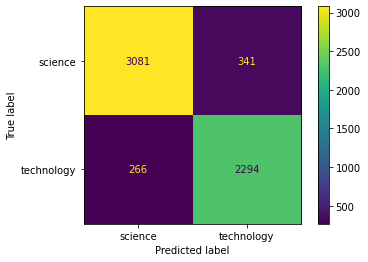

In [31]:
plot_confusion_matrix(grid_tfidf, X_train, y_train);

- False positives: 341 were science, labeled as technology
- False negatives: 266 technology, labled as science

### Tfidf Score

In [32]:
preds_tfidf = grid_tfidf.best_estimator_.predict(X_test)

In [33]:
precision_tfidf = precision_score(y_test, preds_tfidf, pos_label='science')
recall_tfidf = recall_score(y_test, preds_tfidf, pos_label='science')
f1_tfidf = 2 * (precision_tfidf * recall_tfidf) / (precision_tfidf + recall_tfidf)

In [34]:
print(f'The accuracy training score is    {grid_tfidf.score(X_train, y_train)}')
print(f'The accuracy testing score is     {grid_tfidf.score(X_test, y_test)}')
print(f'The bac score is                  {balanced_accuracy_score(y_test, grid_tfidf.predict(X_test))}')
print(f'The f1_score score is             {f1_tfidf}')
print(f'The precision is                  {precision_tfidf}')
print(f'The recall is                     {recall_tfidf}')

The accuracy training score is    0.8985289200936142
The accuracy testing score is     0.8645937813440321
The bac score is                  0.8624486654823467
The f1_score score is             0.881161971830986
The precision is                  0.8850574712643678
The recall is                     0.8773006134969326


- This model did slightly better than without Tfidf

### Lemmatizer

In [35]:
class LemmaTokenizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.lemmatizer.lemmatize(t) for t in word_tokenize(doc)]

In [36]:
pipe_lemtok = make_pipeline(CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', max_features=500),
                    StandardScaler(with_mean=False),
                    LogisticRegression(max_iter=1000))

pipe_lemtok.fit(X_train, y_train)

c:\programdata\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=500, stop_words='english',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x000002CEB201C040>)),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

### Logistic Regression with Lemmatizer

In [37]:
preds_lemtok = pipe_lemtok.predict(X_test)

In [38]:
precision_lemtok = precision_score(y_test, preds_lemtok, pos_label='science')
recall_lemtok = recall_score(y_test, preds_lemtok, pos_label='science')
f1_lemtok = 2 * (precision_lemtok * recall_lemtok) / (precision_lemtok + recall_lemtok)

In [39]:
print(f'The accuracy training score is    {pipe_lemtok.score(X_train, y_train)}')
print(f'The accuracy testing score is     {pipe_lemtok.score(X_test, y_test)}')
print(f'The bac score is                  {balanced_accuracy_score(y_test, pipe_lemtok.predict(X_test))}')
print(f'The f1_score score is             {f1_lemtok}')
print(f'The precision is                  {precision_lemtok}')
print(f'The recall is                     {recall_lemtok}')

The accuracy training score is    0.8749582079572049
The accuracy testing score is     0.8415245737211635
The bac score is                  0.8409593197386551
The f1_score score is             0.8591800356506238
The precision is                  0.8739800543970988
The recall is                     0.8448729184925504


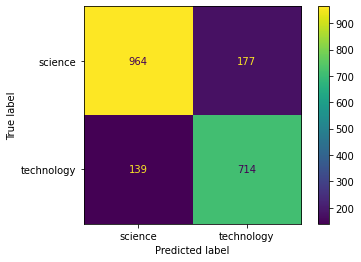

In [40]:
plot_confusion_matrix(pipe_lemtok, X_test, y_test);

- This model did slightly worse overall with balanced accuracy and f1-score.
- This model had less false positives and false negatives.